d:\dataset\dataset_create\pythonProject\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


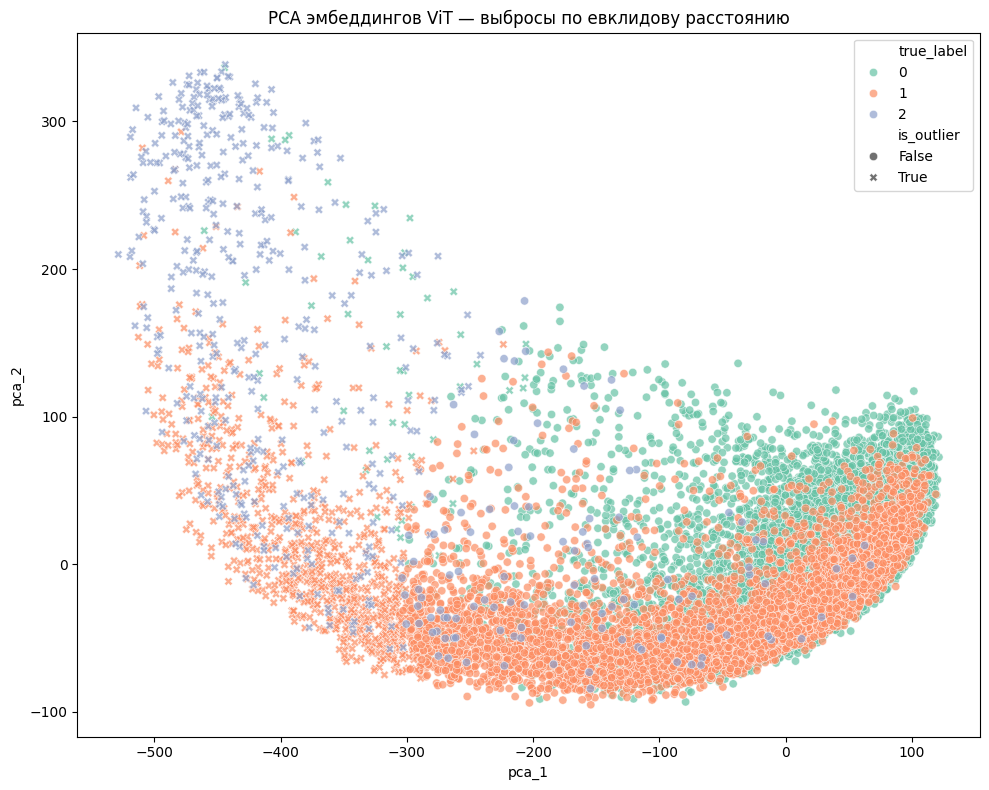

Процесс завершён. Изображения отсортированы по евклидовому расстоянию в пространстве PCA.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from PIL import Image
import yaml
import random
from torchvision import transforms

# === Загрузка настроек ===
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# === Установка сидов ===
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Устройство ===
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")

# === Загрузка модели ViT ===
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
checkpoint_path = "checkpoints/baseline_vit.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# === Датасет и трансформация ===
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name

def get_transform_pipeline(config, label=None):
    return transforms.Compose([
        transforms.Resize(config['dataset']['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

# === Загрузка данных ===
train_csv = config['dataset']['train_csv']
train_df = pd.read_csv(train_csv)
root_dir = 'D:/dataset/_eyepacs/data/ochisheni_no_yarkosti/train'

train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=False)

# === Извлечение эмбеддингов ===
embeddings = []
labels = []
image_paths = []

with torch.no_grad():
    for images, batch_labels, paths in train_loader:
        images = images.to(device)
        outputs = model(pixel_values=images, output_hidden_states=True)
        batch_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

        embeddings.extend(batch_embeddings)
        labels.extend(batch_labels.numpy())
        image_paths.extend(paths)

embeddings = np.array(embeddings)
labels = np.array(labels)

# === PCA и удаление выбросов по евклидову расстоянию от центра ===
pca = PCA(n_components=30, svd_solver='randomized', random_state=seed)
embeddings_pca = pca.fit_transform(embeddings)

# Центроид по всему пространству
global_center = np.mean(embeddings_pca, axis=0)
distances = euclidean_distances(embeddings_pca, [global_center]).flatten()

# 95-й перцентиль — отсечка для выбросов
threshold = np.percentile(distances, 95)

# Размечаем выбросы
df = train_df.copy()
df['distance'] = distances
df['is_outlier'] = df['distance'] > threshold

# PCA для визуализации (2D)
pca_vis = PCA(n_components=2)
pca_2d = pca_vis.fit_transform(embeddings)
df['pca_1'] = pca_2d[:, 0]
df['pca_2'] = pca_2d[:, 1]

# === Визуализация ===
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='true_label', style='is_outlier', palette='Set2', alpha=0.7)
plt.title("PCA эмбеддингов ViT — выбросы по евклидову расстоянию")
plt.tight_layout()
plt.show()

# === Сохранение изображений ===
output_train = Path('D:/dataset/_eyepacs/data/center_evklid/train')
output_trash = Path('D:/dataset/_eyepacs/data/center_evklid/trash')
output_train.mkdir(parents=True, exist_ok=True)
output_trash.mkdir(parents=True, exist_ok=True)

for i, row in df.iterrows():
    label = str(row['true_label'])
    img_name = row['image_name']
    src_path = Path(root_dir) / label / img_name
    dst_dir = output_trash if row['is_outlier'] else output_train
    shutil.copy2(src_path, dst_dir / img_name)

print("Процесс завершён. Изображения отсортированы по евклидовому расстоянию в пространстве PCA.")


In [4]:
output_csv_path = Path("D:/dataset/_eyepacs/data/center_evklid/center_evklid_train.csv")
# Сохраняем новый CSV
df_filtered.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

print("Разделение завершено. CSV сохранён как:", output_csv_path)

Разделение завершено. CSV сохранён как: D:\dataset\_eyepacs\data\center_evklid\center_evklid_train.csv
